In [2]:
import evoVAE.utils.seq_tools as st
from evoVAE.utils.datasets import MSA_Dataset
from evoVAE.models.seqVAETest import SeqVAETest
import evoVAE.utils.statistics as stats
import pandas as pd
import torch


pd.set_option("display.max_rows", None)

(14276, 4)


In [3]:
test_aln = st.read_aln_file("../data/pair_test.aln")
#test_aln = pd.read_pickle("../data/gb1/gb1_ancestors_extants_encoded_weighted_no_dupes.pkl")
test_aln.head()


Reading the alignment: ../data/pair_test.aln
Checking for bad characters: ['B', 'J', 'X', 'Z']
Performing one hot encoding
Number of seqs: 8


,id,sequence,encoding
0,seq_1,LTRAALYEDC,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,seq_2,LTRATLYEDC,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,seq_3,LTRCTLPEDC,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,seq_4,LRRATLPDDC,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,seq_5,LRRATLPDDA,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [4]:

train_dataset = MSA_Dataset(test_aln["encoding"], test_aln["weights"], test_aln["id"])
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=False
)

SEQ_LEN = 0
BATCH_ZERO = 0
SEQ_ZERO = 0
seq_len = train_dataset[BATCH_ZERO][SEQ_ZERO].shape[SEQ_LEN]
input_dims = seq_len * 21


config={
            # Dataset info
            "alignment": "tets",
            "seq_theta": 0.2,  # reweighting
            "AA_count": 21,  # standard AA + gap
            "test_split": 0.2,
            "max_mutation": 4,  # how many mutations the model will test up to
            # ADAM
            "learning_rate": 1e-2,  # ADAM
            "weight_decay": 1e-4,  # ADAM
            # Hidden units
            "momentum": None,
            "dropout": None,
            # Training loop
            "epochs": 500,
            "batch_size": 128,
            "max_norm": 10,  # gradient clipping
            "patience": 3,
            # Model info - default settings
            "architecture": f"SeqVAE_0.25_ancestors_R",
            "latent_dims": 2,
            "hidden_dims": [256, 128, 64],
            # DMS data
            "dms_file": "../data/SPG1_STRSG_Wu_2016.pkl",
            "dms_metadata": "../data/DMS_substitutions.csv",
            "dms_id": "SPG1_STRSG_Wu_2016",
}



SEQ_LEN = 0
BATCH_ZERO = 0
SEQ_ZERO = 0
seq_len = train_dataset[BATCH_ZERO][SEQ_ZERO].shape[SEQ_LEN]
input_dims = seq_len * 21


good_weights = "../data/gfp/model_weights/ancestors_extants_no_duplicates_gfp_model_state.pt"
gb1_good = "../data/gb1/model_weights/gb1_ancestors_extants_no_dupes_model_state.pt"
bad_weights = "../data/gfp/model_weights/bad_loss/gfp_ancestors_extants_no_duplicates_model_state.pt"
model = SeqVAETest(input_dims, 2, hidden_dims=config["hidden_dims"], config=config)
model.load_state_dict(torch.load(gb1_good))
model.eval()

KeyError: 'weights'

In [21]:

names = []
z_vals = []

num_samples = 50
for encoding, weights, name in train_loader:

    encoding = encoding.float()
    encoding = torch.flatten(encoding, start_dim=1)
    #print(encoding.shape)

    encoding = encoding.expand(num_samples, encoding.shape[0], encoding.shape[1])
    #print(encoding.shape)
    #print(encoding.shape)
    z_mu, z_logvar = model.encode(encoding.float())
    z_samples = model.reparameterise(z_mu, z_logvar)
    #print(z_samples.shape)
    #print(z_samples[:, 0, :])
    mean_z = torch.mean(z_samples, dim=0)
    
    names.extend(name)
    z_vals.extend(mean_z.detach().numpy())


print(len(names))
print(len(z_vals))
id_to_z = pd.DataFrame({"taxa": names, "z": z_vals})
id_to_z.tail()

14276
14276


,taxa,z
14271,UniRef100_UPI000768A238/12-386,"[0.0941095, 0.60755223]"
14272,UniRef100_UPI001959AF38/4-600,"[-0.01640377, -1.0976197]"
14273,UniRef100_UPI000765255D/5-423,"[-0.005554657, 0.9799295]"
14274,UniRef100_UPI001454C06F/5-327,"[0.04587064, 0.8399803]"
14275,UniRef100_A0A1B3PUX7/506-955,"[-0.0063712858, -0.40507004]"


In [23]:
import torch.nn.functional as F
import evoVAE.utils.seq_tools as st
import evoVAE.utils.metrics as mt

count = 0
inputs = []
recons = []
# EVALUATE DIFFERENCES BETWEEN THE RECONSTRUCTIONS AND INPUT 
for id, z in zip(id_to_z['taxa'], id_to_z['z']):

    # decode the Z sample and get it into a PPM shape 
    x_hat = model.decode(torch.tensor(z))
    x_hat = x_hat.unsqueeze(-1)
    #print(x_hat.shape)

    x = test_aln[test_aln['id'] == id]['sequence'].values[0]
    x_one_hot = torch.tensor(st.seq_to_one_hot(x))
    #print(x_one_hot.shape)

    orig_shape = tuple(x_one_hot.shape)
    x_hat = x_hat.view(orig_shape)

    indices = x_hat.max(dim=-1).indices.tolist()
    
    orig = test_aln[test_aln['id'] == id]['sequence'].values[0]
    inputs.append(orig)
    recon = "".join([st.GAPPY_PROTEIN_ALPHABET[x] for x in indices])
    recons.append(recon)

    #hamming_dist += mt.hamming_distance(orig, recon)
    #count += 1

print(len(recons))
print(len(inputs))

14276
14276


In [6]:
H = stats.calc_shannon_entropy(test_aln)


Sequence weight numpy array created with shape (num_seqs, columns):  (8, 10)


In [27]:


from evoVAE.utils.seq_tools import AA_TO_IDX, GAPPY_ALPHABET_LEN
import numpy as np

def pair_wise_covariances(msa):

    SEQ_COUNT = 0
    COLS = 1

    pairs = []
    for i in range(st.GAPPY_ALPHABET_LEN):
        pairs.extend([(i, j) for j in range(i + 1, st.GAPPY_ALPHABET_LEN)])

    # the number of unique ways we can compare columns in the MSA 
    column_combinations = (msa.shape[COLS] * (msa.shape[COLS] - 1) // 2)
    # number of different residue combinations we can have 
    aa_combinations = GAPPY_ALPHABET_LEN ** 2

    num_seqs = msa.shape[SEQ_COUNT]
    num_columns = msa.shape[COLS]

    # each column has aa_combinations many ways to combine residues
    # this is an upper triangular matrix but we will store it in a linear format. 
    covariances = np.zeros(column_combinations * aa_combinations)

    # keep track of which column combination we're up to 
    col_combination_count = 0
    for i in range(num_columns - 1):
        for j in range(i + 1, num_columns):
            col_i = msa[:, i]
            col_j = msa[:, j]

            for a, b in pairs:
      
                # find how many sequences have residues a and b
                col_i_res = np.where(col_i == a)[0]
                col_j_res = np.where(col_j == b)[0]

                # find how many sequences have this combination 
                intersect = np.intersect1d(col_i_res, col_j_res, assume_unique=True).shape[SEQ_COUNT]
                # make a frequency based on number of sequences 
                freq_Ai_Bj = intersect / num_seqs
                
                # just count how many sequences have these residues 
                freq_Ai = col_i_res.shape[0] / num_seqs
                freq_Bj = col_j_res.shape[0] / num_seqs

                # get correct position: (which column combination we're at) + (which residue combination we're at)
                covar_index = col_combination_count * aa_combinations + a * st.GAPPY_ALPHABET_LEN + b

                # useful in case you want to find a specific cov score based on column and residue indices in the upper tri matrix
                #col_combination_count = (num_cols*(num_cols-1)/2) - (num_cols-col_1_idx)*((num_cols-col_1_idx)-1)/2 + col_2_idx - col_1_idx - 1
                #covar_index = int(col_combination_count * aa_combinations + a_idx * st.GAPPY_ALPHABET_LEN + b_idx)

                # (joint occurances of residues a & b at thi) - (occurence of A at col i * occurence of B at col j)
                covariances[covar_index] = freq_Ai_Bj - (freq_Ai * freq_Bj)

            # keep track of how many column combinations we've seen 
            col_combination_count += 1

    
    return covariances

msa, _, _ = st.convert_msa_numpy_array(test_aln)
pairs = pair_wise_covariances(msa)
print(pairs.shape)
#pairs.shape

Sequence weight numpy array created with shape (num_seqs, columns):  (14276, 448)


KeyboardInterrupt: 

In [1]:
import pandas as pd
gb1_corv_data = pd.read_csv("../data/gb1_3000_corv.csv")
gb1_corv_data.head()

,Unnamed: 0,actual,prediction
0,0,0.000000,0.000000
1,1,0.000000,0.000000
2,2,0.000000,0.000000
3,3,0.004469,0.004503
4,4,0.000000,0.000000


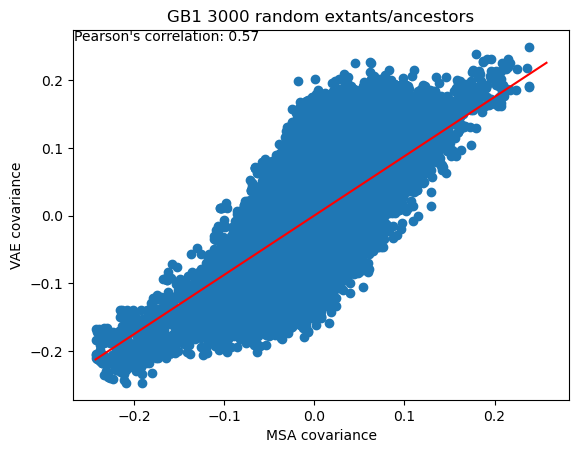

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(gb1_corv_data['actual'], gb1_corv_data['prediction'])
plt.xlabel("MSA covariance")
plt.ylabel("VAE covariance")
slope, intercept = np.polyfit(gb1_corv_data['actual'], gb1_corv_data['prediction'], 1)
x = np.arange(min(gb1_corv_data['actual']),max(gb1_corv_data['actual']) + 0.1, 0.1)
regression_line = slope * x + intercept

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(gb1_corv_data['actual'], gb1_corv_data['prediction'])[0, 1]

# Display correlation value
plt.text(plt.xlim()[0], plt.ylim()[1], f'Pearson\'s correlation: {correlation_coefficient:.2f}', va='top')

# Plot regression line
plt.plot(x, regression_line, color='red')
plt.title("GB1 3000 random extants/ancestors")
plt.show()

In [9]:
dataset = "../../asdfajsdflka"

test = f"testing_{dataset.split('/')[-1]}"
test

'testing_asdfajsdflka'